Use adaboost, Gradient Tree Boosting and xgboosting

# NOTES:
Der er nogle ting du skal tilbage og havde styr på. 

Baglens:

- Du skal have flere variabler med herover den først runde feature selection skal kun være helt grov ect vægle mellem log eller ike log ect.
- Der er pludseligt en helt masse missing i dit y!? wth! får lige styr på den kat..
- i forgående gem df som goepandas.dataframe i pickle
- i forgående gem df (- geometry) som padas.dataframe i csv
- ændre navn fatilities i forgående og lav også en logged version.
- Se generelt din estimation for hvad der giver mening som logged...

forlens:

- 1000 random less-unbalanced xgboosts to get a distribution of metric results
- tree graph
- world map of predict vs true. (proba vs log(best) t+1 or pred vs binary_best t +1)
- world map of diff between binary pred and true.
- Use the true hold-out-set.
- Robustness test with only new onsets
- you can easely do basian correction: even country (or something) specific

$$P(død)=\frac{xgboost\_est\_(dist) * country\_mean }{xgboost\_est\_(dist) * country\_mean + (1-xgboost\_est\_(dist)) * (1-country\_mean) }$$

men hvis du vil gøre det med dists kan du vel ikke bruge $1-$..

- det må være et empirisk spørgsmål om 1/1, 1/30, 1/1 med B-correction eller 1/30 med B-correction er bedst.

- tjek if your model gets worse the more years we move away from 2005

In [265]:
import numpy as np
import pandas as pd
import geopandas as gpd

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb 
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, average_precision_score, recall_score, precision_recall_curve, roc_auc_score, roc_curve, precision_score, accuracy_score
from sklearn.utils.fixes import signature


In [266]:

pkl_file = open('full_df.pkl', 'rb')

df = pickle.load(pkl_file)

pkl_file.close()

df.dropna(inplace = True) # do to some unknown fuckery in the last script.. to fix later

In [267]:
df.shape

(1267740, 62)

In [268]:

# pkl_file = open('chosen_df.pkl', 'rb')

# df = pickle.load(pkl_file)

# pkl_file.close()

# df.dropna(inplace = True) # do to some unknown fuckery in the last script.. to fix later

In [269]:

# Balanced: 

# df_train_1 = df_train[df_train['lead_binary_best'] == 1]
# df_train_0 = df_train[df_train['lead_binary_best'] == 0].sample(df_train_1.shape[0])

# df_train_ss = pd.concat([df_train_0,df_train_1])

#df = df_train_ss.sample(10000)

In [270]:

# X_labels = ['landarea', 'ttime_mean', 'mountains_mean', 'year',
#        'interp_pop_gpw_sum', 'interp_gcp_ppp', 'interp_urban_ih',
#        'interp_agri_ih', 'interp_forest_ih', 'gwarea', 'bdist1',
#        'bdist3', 'capdist', 'excluded', 'nlights_calib_mean', 'best',
#        'log_best', 'petroleum_full', 'binary_best', 'past_fatalities', 'past_conflicts',
#        'fatilities_country_year', 'conflict_country_year', 'nearest_conflict',
#        'mean_light', 'low_ratio_light', 'high_ratio_light',
#        'country_year_median_light', 'diff_median_light', 'excluded_binary',
#        'sum_nlight', 'country_pop_sum', 'light_capita_country',
#        'light_capita_country_std', 'light_capita_cell',
#        'light_capita_cell_std', 'country_area_sum', 'pop_cell_dens',
#        'pop_country_dens', 'log_ttime_mean', 'log_interp_pop_gpw_sum',
#        'log_interp_urban_ih', 'log_interp_agri_ih', 'log_interp_forest_ih',
#        'log_bdist1', 'log_bdist3', 'log_capdist', 'log_past_fatalities',
#        'log_fatilities_country_year', 'log_nearest_conflict',
#        'log_country_pop_sum', 'log_light_capita_country_std',
#        'log_light_capita_cell_std', 'log_country_area_sum',
#        'log_pop_cell_dens', 'log_pop_country_dens']


#X_labels = ['nearest_conflict', 'past_fatalities', 'country_area_sum', 'best', 'fatilities_country_year', 'light_capita_cell', 'interp_pop_gpw_sum','past_conflicts','interp_urban_ih','low_ratio_light']

#X_labels = ['nearest_conflict', 'past_fatalities', 'country_area_sum', 'best','fatilities_country_year','light_capita_cell','interp_pop_gpw_sum','past_conflicts','low_ratio_light']

X_labels = ['nearest_conflict', 'past_fatalities', 
            'country_area_sum', 'best','fatilities_country_year', 
            'light_capita_cell','interp_pop_gpw_sum',
            'past_conflicts','low_ratio_light', 
            'bdist1','bdist3', 'ttime_mean',
            'capdist','mountains_mean',
            'excluded_binary','petroleum_full',
            'country_pop_sum','light_capita_country']



# The functions:

**Du mangler stadigt at gemme din "posterior" aka alle forudsiagte y_tilde (i out_years modellerne.)**

In [271]:
# dict of metrics

def cons_dict_of_metric():
    # Construct the empty dict of matrics and other stuff
    dict_of_metrics = {}
    dict_of_metrics['auc'] = []
    dict_of_metrics['ap'] = []

    dict_of_metrics['recall50'] = []
    dict_of_metrics['recall75'] = []
    dict_of_metrics['recall95'] = []

    dict_of_metrics['precision50'] = []
    dict_of_metrics['precision75'] = []
    dict_of_metrics['precision95'] = []
    
    dict_of_metrics['accuracy50'] = []
    
    #roc,rp, feature imp
    
    dict_of_metrics['roc'] = []
    dict_of_metrics['prc'] = []
    dict_of_metrics['feature_imp'] = []
    
    return(dict_of_metrics)

In [272]:
def in_years_estimation(sample_sizs = 100):
    
    # if you could multiprocesse it. like multiple chains. that would be nice..
    
    # Hold out years:
    df_test_years = df[df['year']>2005].copy()
    df_train_years = df[df['year']<=2005].copy()

    #radnom seeds for loop (culd do without, but it eases intpr.)
    random_seeds = np.random.randint(1000,9999,1000)

    # dict of metrics
    dict_of_metrics = cons_dict_of_metric()    

    # add more and roc + ap-curve data later on.
    # And feature imp!


    # feature and target labels:

#     X_labels = ['fatilities_country_year', 'log_best', 'log_country_area_sum',
#             'low_ratio_light', 'nearest_conflict', 'nlights_calib_mean',
#             'past_conflicts', 'excluded_binary', 'petroleum_full',
#             'diff_median_light','binary_best', 'pop_cell_dens', 
#             'log_interp_pop_gpw_sum','conflict_country_year']

    y_label = 'lead_binary_best'

    df_train_years_1 = df_train_years[df_train_years['lead_binary_best'] == 1] # events

    #for loop
    for i in range(sample_sizs):

        # The data:
        # the non_events! rigth now 1000 percent
        df_train_years_0 = df_train_years[df_train_years['lead_binary_best'] == 0].sample(df_train_years_1.shape[0], random_state = random_seeds[i])

        #Merge events and non-events; rigth now 10/100
        df_train_years_01 = pd.concat([df_train_years_0,df_train_years_1])

        # dfine X and y
        X = df_train_years_01[X_labels]

        y = df_train_years_01[y_label]

        # test_train: TEMP:
        # Create the training and test sets
        X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=random_seeds[i])


        # the model
        # Instantiate the XGBClassifier: xg_cl
        xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=random_seeds[i])

        # Fit the classifier to the training set
        xg_cl.fit(X_train, y_train)

        # Predict the labels of the test set: preds
        preds = xg_cl.predict_proba(X_test)
        
        preds50 = (preds[:,1] >= 0.5)*1 # binary class with thresshold at 0.5 (standart)
        preds75 = (preds[:,1] >= 0.75)*1 # binary class with thresshold at 0.75 (standart)
        preds95 = (preds[:,1] >= 0.95)*1 # binary class with thresshold at 0.95 (standart)

        dict_of_metrics['ap'].append(average_precision_score(y_test,preds[:,1]))
        dict_of_metrics['auc'].append(roc_auc_score(y_test,preds[:,1]))

        dict_of_metrics['recall50'].append(recall_score(y_test, preds50))
        dict_of_metrics['recall75'].append(recall_score(y_test, preds75))
        dict_of_metrics['recall95'].append(recall_score(y_test, preds95))

        dict_of_metrics['precision50'].append(precision_score(y_test, preds50))
        dict_of_metrics['precision75'].append(precision_score(y_test, preds75))
        dict_of_metrics['precision95'].append(precision_score(y_test, preds95))
        
        dict_of_metrics['accuracy50'].append(accuracy_score(y_test,preds50))
        
        dict_of_metrics['prc'].append(precision_recall_curve(y_test,preds[:,1]))
        dict_of_metrics['roc'].append(roc_curve(y_test, preds[:, 1]))
    
        dict_of_metrics['feature_imp'].append(xg_cl.feature_importances_)

        print(i, end='_')

    return(dict_of_metrics)

In [273]:
def out_years_estimation(sample_size = 100, balance_parameter = 1):    
    
    # Hold out years:
    df_test_years = df[df['year']>2005].copy()
    df_train_years = df[df['year']<=2005].copy()

    #radnom seeds for loop (culd do without, but it eases intpr.)
    random_seeds = np.random.randint(1000,9999,1000)

    # dict of metrics
    dict_of_metrics = cons_dict_of_metric()    
    dict_of_metrics['preds'] = []

    # feature and target labels:

#     X_labels = ['fatilities_country_year', 'log_best', 'log_country_area_sum',
#             'low_ratio_light', 'nearest_conflict', 'nlights_calib_mean',
#             'past_conflicts', 'excluded_binary', 'petroleum_full',
#             'diff_median_light','binary_best', 'pop_cell_dens', 
#             'log_interp_pop_gpw_sum','conflict_country_year']

    y_label = 'lead_binary_best'

    df_train_years_1 = df_train_years[df_train_years['lead_binary_best'] == 1] # events


    #for loop
    for i in range(sample_size):

        # The data:
        # the non_events! rigth now 1000 percent
        df_train_years_0 = df_train_years[df_train_years['lead_binary_best'] == 0].sample(df_train_years_1.shape[0]*balance_parameter, random_state = random_seeds[i]) 
        # you shoul dmeak one with *1 and *20 manke it an input in the function 

        #Merge events and non-events; rigth now 10/100
        df_train_years_01 = pd.concat([df_train_years_0,df_train_years_1])

        # dfine X and y
        X_train = df_train_years_01[X_labels]

        y_train = df_train_years_01[y_label]

        # test_train: TEMP:
        # Create the training and test sets
        #X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=random_seeds[i])

        X_test = df_test_years[X_labels]
        y_test = df_test_years[y_label]

        # the model
        # Instantiate the XGBClassifier: xg_cl
        xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=random_seeds[i])

        # Fit the classifier to the training set
        xg_cl.fit(X_train, y_train)

        # Predict the labels of the test set: preds
        preds = xg_cl.predict_proba(X_test)

        preds50 = (preds[:,1] >= 0.5)*1 # binary class with thresshold at 0.5 (standart)
        preds75 = (preds[:,1] >= 0.75)*1 # binary class with thresshold at 0.75 (standart)
        preds95 = (preds[:,1] >= 0.95)*1 # binary class with thresshold at 0.95 (standart)

        dict_of_metrics['ap'].append(average_precision_score(y_test,preds[:,1]))
        dict_of_metrics['auc'].append(roc_auc_score(y_test,preds[:,1]))

        dict_of_metrics['recall50'].append(recall_score(y_test, preds50))
        dict_of_metrics['recall75'].append(recall_score(y_test, preds75))
        dict_of_metrics['recall95'].append(recall_score(y_test, preds95))

        dict_of_metrics['precision50'].append(precision_score(y_test, preds50))
        dict_of_metrics['precision75'].append(precision_score(y_test, preds75))
        dict_of_metrics['precision95'].append(precision_score(y_test, preds95))
        
        dict_of_metrics['accuracy50'].append(accuracy_score(y_test,preds50))
        
        dict_of_metrics['prc'].append(precision_recall_curve(y_test,preds[:,1]))
        dict_of_metrics['roc'].append(roc_curve(y_test, preds[:, 1]))
    
        dict_of_metrics['feature_imp'].append(xg_cl.feature_importances_)
        
        dict_of_metrics['preds'].append(preds) # nice to have both columns for the baysian correction

        print(i, end='_')

    return(dict_of_metrics)

In [274]:
def out_years_estimation_onsets(sample_size = 100, balance_parameter = 1):   
    
    df_ongoing = df[(df['lead_binary_best']==1)&(df['binary_best'] == 1)]
    df_onset = df[~((df['lead_binary_best']==1)&(df['binary_best'] == 1))]
    
    print('Number of observation/conflicts discarded: {}'.format(df_ongoing.shape[0]))
    print('Number of observation preserved: {}'.format(df_onset.shape[0]))
    print('Number of conflicts preserved: {}'.format(df_onset[df_onset['lead_binary_best'] == 1].shape[0]))
    
    # Hold out years:
    df_test_years = df_onset[df_onset['year']>2005].copy()
    df_train_years = df_onset[df_onset['year']<=2005].copy()

    #radnom seeds for loop (culd do without, but it eases intpr.)
    random_seeds = np.random.randint(1000,9999,1000)

    # dict of metrics
    dict_of_metrics = cons_dict_of_metric()    
    dict_of_metrics['preds'] = []

    # add more and roc + ap-curve data later on.
    # And feature imp!


    # feature and target labels:

#     X_labels = ['fatilities_country_year', 'log_best', 'log_country_area_sum',
#             'low_ratio_light', 'nearest_conflict', 'nlights_calib_mean',
#             'past_conflicts', 'excluded_binary', 'petroleum_full',
#             'diff_median_light','binary_best', 'pop_cell_dens', 
#             'log_interp_pop_gpw_sum','conflict_country_year']

    y_label = 'lead_binary_best'
    
    
    df_train_years_1 = df_train_years[df_train_years['lead_binary_best'] == 1] # events


    #for loop
    for i in range(sample_size):

        # The data:
        # the non_events! rigth now 1000 percent
        df_train_years_0 = df_train_years[df_train_years['lead_binary_best'] == 0].sample(df_train_years_1.shape[0]*balance_parameter, random_state = random_seeds[i]) 
        # you shoul dmeak one with *1 and *20 manke it an input in the function 

        #Merge events and non-events; rigth now 10/100
        df_train_years_01 = pd.concat([df_train_years_0,df_train_years_1])

        # dfine X and y
        X_train = df_train_years_01[X_labels]

        y_train = df_train_years_01[y_label]

        # test_train: TEMP:
        # Create the training and test sets
        #X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=random_seeds[i])

        X_test = df_test_years[X_labels]
        y_test = df_test_years[y_label]

        # the model
        # Instantiate the XGBClassifier: xg_cl
        xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=random_seeds[i])

        # Fit the classifier to the training set
        xg_cl.fit(X_train, y_train)

        # Predict the labels of the test set: preds
        preds = xg_cl.predict_proba(X_test)

        preds50 = (preds[:,1] >= 0.5)*1 # binary class with thresshold at 0.5 (standart)
        preds75 = (preds[:,1] >= 0.75)*1 # binary class with thresshold at 0.75 (standart)
        preds95 = (preds[:,1] >= 0.95)*1 # binary class with thresshold at 0.95 (standart)

        dict_of_metrics['ap'].append(average_precision_score(y_test,preds[:,1]))
        dict_of_metrics['auc'].append(roc_auc_score(y_test,preds[:,1]))

        dict_of_metrics['recall50'].append(recall_score(y_test, preds50))
        dict_of_metrics['recall75'].append(recall_score(y_test, preds75))
        dict_of_metrics['recall95'].append(recall_score(y_test, preds95))

        dict_of_metrics['precision50'].append(precision_score(y_test, preds50))
        dict_of_metrics['precision75'].append(precision_score(y_test, preds75))
        dict_of_metrics['precision95'].append(precision_score(y_test, preds95))

        dict_of_metrics['accuracy50'].append(accuracy_score(y_test,preds50))
        
        dict_of_metrics['prc'].append(precision_recall_curve(y_test,preds[:,1]))
        dict_of_metrics['roc'].append(roc_curve(y_test, preds[:, 1]))
    
        dict_of_metrics['feature_imp'].append(xg_cl.feature_importances_)
        
        dict_of_metrics['preds'].append(preds) # nice to have both columns for the baysian correction

        print(i, end='_')

    return(dict_of_metrics)

## plot functions:

In [275]:

def dist_point_plot(dict_of_metrics, metric, color, title = 'Title', show = True):

    label = metric + ': ' + str(np.mean(dict_of_metrics[metric]).round(3))
    
    plt.hist(dict_of_metrics[metric], density=True, label = label, alpha = 0.5, color = color)
    sns.kdeplot(dict_of_metrics[metric], color = color)
    
    plt.title(title, fontsize = 14)
    
    plt.legend()
    plt.yticks([])
    sns.despine(left=True)
    plt.xlabel('metric score', fontsize = 12)
    
    if show == True:
    
        plt.show()


In [276]:
def auc_plot(dict_of_metrics, color = 'C0'):
    
    plt.figure(figsize=[15,5])
    
    metric = 'auc'
    title = metric + ' distrubtion'
    
    dist_point_plot(dict_of_metrics, metric, color, title)
    
    
def ap_plot(dict_of_metrics, color = 'C1'):
        
    plt.figure(figsize=[15,5])
    
    metric = 'ap'
    title = 'Avarega Precision (presicion-recall rate) distrubtion'
    
    dist_point_plot( dict_of_metrics, metric, color, title)
    
    
def acc_plot(dict_of_metrics, color = 'C2'):
    
    plt.figure(figsize=[15,5])
    
    metric = 'accuracy50'
    title = 'accuracy distrubtion'

    dist_point_plot( dict_of_metrics, metric, color, title)
    
    
def recall_precision_plot(dict_of_metrics, colors = ['C3','C4','C5','C6','C7','C8']):
    
    plt.figure(figsize=[15,5])
    
    metric_list = ['recall50',
                   'recall75',
                   'recall95',
                   'precision50',
                   'precision75',
                   'precision95']
    
    title = 'presision and recall distrubtions at different thresholds'

        
    for i in range(6):
    
        metric = metric_list[i]
        dist_point_plot( dict_of_metrics, metric, colors[i], show = False, title=title)
        
    plt.show()


In [277]:
def prc_plot(dict_of_metrics, color = 'C0', model_title = 'MODEL'):

    plt.figure(figsize = [7,7])
    
    precision, recall, _ = dict_of_metrics['prc'][0] # but that is just the fist. You have a dist

    #In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    
    plt.step(recall, precision, color=color, alpha=0.5,
             where='post')
    
    plt.fill_between(recall, precision, alpha=0.2, color=color, **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    
    title = model_title + '\nPrecision-Recall curve: AP={0:0.2f}'.format(np.mean(dict_of_metrics['ap']))
    
    plt.title(title)

    sns.despine()
    
    plt.show()

In [278]:
def roc_plot(dict_of_metrics, color = 'C0', model_title = 'MODEL'):

    plt.figure(figsize = [7,7])
    
    fpr, tpr, threshold = dict_of_metrics['roc'][0] # but that is just the fist. You have a dist
    
    plt.plot(fpr, tpr, color=color, alpha=0.5)
    
    plt.plot([0,1],[0,1], color = 'gray', linestyle = 'dashed')
    
    #plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)    
    
    plt.xlabel('False Positive Rate', fontsize =12)
    plt.ylabel('True Positive Rate', fontsize = 12)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    
    title = model_title + '\nROC curve: AUC={0:0.2f}'.format(np.mean(dict_of_metrics['auc']))
    
    plt.title(title, fontsize = 14)

    sns.despine()
    
    plt.show()

In [279]:
def feature_imp_plot(dict_of_metrics):
    
#     X_labels = ['fatilities_country_year', 'log_best', 'log_country_area_sum',
#             'low_ratio_light', 'nearest_conflict', 'nlights_calib_mean',
#             'past_conflicts', 'excluded_binary', 'petroleum_full',
#             'diff_median_light','binary_best', 'pop_cell_dens', 
#             'log_interp_pop_gpw_sum','conflict_country_year']


    #importances = xg_cl.feature_importances_
    importances = np.array(dict_of_metrics['feature_imp']).mean(0)
    importances_std = np.array(dict_of_metrics['feature_imp']).std(0)


    indices = np.argsort(importances)[::-1]

    size = len(importances)

    plt.figure(figsize=[15,int(size/3)])

    plt.title("Feature importances")


    plt.barh(range(size), importances[indices], color="salmon", align="center", yerr=importances_std[indices])

    plt.yticks(range(size),  np.array(X_labels)[indices])
    plt.ylim([-1, size])

    plt.xlabel('gain')
    plt.ylabel('features')

    sns.despine()
    plt.show()


In [280]:
# "Posterior predicte check plot" aka hist of porb dist. plot function

# Estimates:

But you still need to go back and optimize the hyper parameters. But that is not paramount for now.

In [281]:
dict_of_metrics_in_years = in_years_estimation(100)

0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_17_18_19_20_21_22_23_24_25_26_27_28_29_30_31_32_33_34_35_36_37_38_39_40_41_42_43_44_45_46_47_48_49_50_51_52_53_54_55_56_57_58_59_60_61_62_63_64_65_66_67_68_69_70_71_72_73_74_75_76_77_78_79_80_81_82_83_84_85_86_87_88_89_90_91_92_93_94_95_96_97_98_99_

In [282]:
dict_of_metrics_out_years = out_years_estimation(100)

0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_17_18_19_20_21_22_23_24_25_26_27_28_29_30_31_32_33_34_35_36_37_38_39_40_41_42_43_44_45_46_47_48_49_50_51_52_53_54_55_56_57_58_59_60_61_62_63_64_65_66_67_68_69_70_71_72_73_74_75_76_77_78_79_80_81_82_83_84_85_86_87_88_89_90_91_92_93_94_95_96_97_98_99_

In [283]:
dict_of_metrics_out_years_onsets = out_years_estimation_onsets(100)

Number of observation/conflicts discarded: 6887
Number of observation preserved: 1260853
Number of conflicts preserved: 6410
0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_17_18_19_20_21_22_23_24_25_26_27_28_29_30_31_32_33_34_35_36_37_38_39_40_41_42_43_44_45_46_47_48_49_50_51_52_53_54_55_56_57_58_59_60_61_62_63_64_65_66_67_68_69_70_71_72_73_74_75_76_77_78_79_80_81_82_83_84_85_86_87_88_89_90_91_92_93_94_95_96_97_98_99_

In [284]:
dict_of_metrics_out_years20 = out_years_estimation(100, 20)

0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_17_18_19_20_21_22_23_24_25_26_27_28_29_30_31_32_33_34_35_36_37_38_39_40_41_42_43_44_45_46_47_48_49_50_51_52_53_54_55_56_57_58_59_60_61_62_63_64_65_66_67_68_69_70_71_72_73_74_75_76_77_78_79_80_81_82_83_84_85_86_87_88_89_90_91_92_93_94_95_96_97_98_99_

In [285]:
dict_of_metrics_out_years_onsets5 = out_years_estimation_onsets(100,5)

Number of observation/conflicts discarded: 6887
Number of observation preserved: 1260853
Number of conflicts preserved: 6410
0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_17_18_19_20_21_22_23_24_25_26_27_28_29_30_31_32_33_34_35_36_37_38_39_40_41_42_43_44_45_46_47_48_49_50_51_52_53_54_55_56_57_58_59_60_61_62_63_64_65_66_67_68_69_70_71_72_73_74_75_76_77_78_79_80_81_82_83_84_85_86_87_88_89_90_91_92_93_94_95_96_97_98_99_

# Save as Pickle:

In [286]:
dict_of_dicts = {}
dict_of_dicts['dict_of_metrics_in_years'] = dict_of_metrics_in_years
dict_of_dicts['dict_of_metrics_out_years'] = dict_of_metrics_out_years
dict_of_dicts['dict_of_metrics_out_years_onsets'] = dict_of_metrics_out_years_onsets
dict_of_dicts['dict_of_metrics_out_years20'] = dict_of_metrics_out_years20
dict_of_dicts['dict_of_metrics_out_years_onsets5'] = dict_of_metrics_out_years_onsets5

In [287]:
import pickle 
    
file_name = "dict_of_dicts.pkl"
output = open(file_name, 'wb') #
pickle.dump(dict_of_dicts, output)
output.close()

# plots:
**Skal være i anden note book**

** Så skal functioner også der over i stedet for at ligge her.**

MEN TJEK LIGE ET PLOT FØRST!

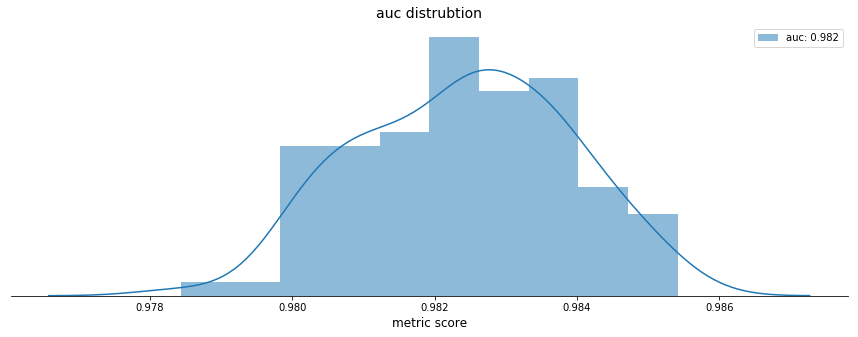

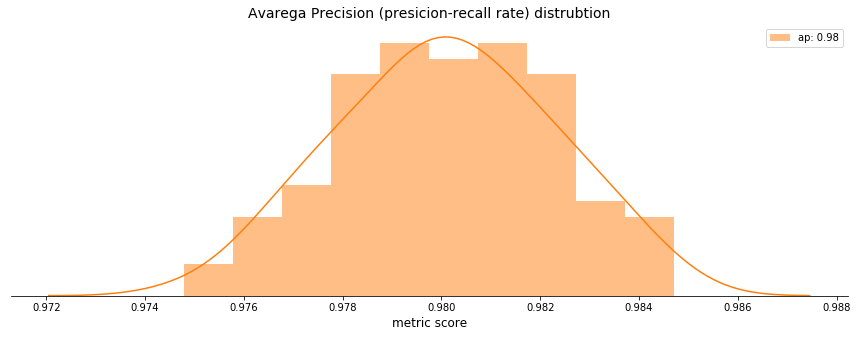

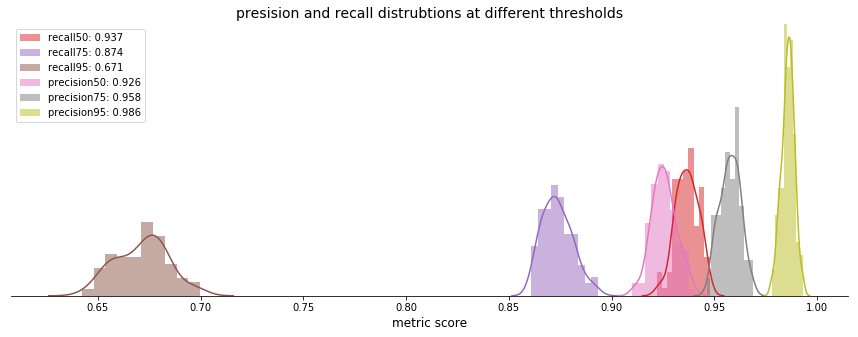

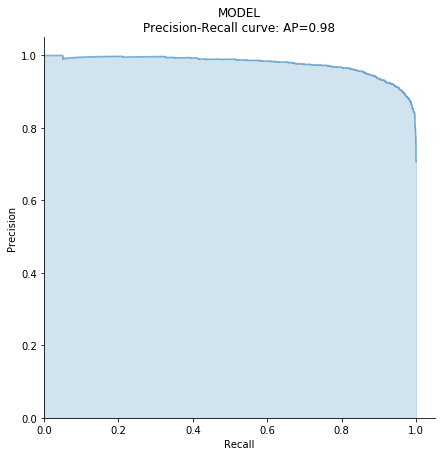

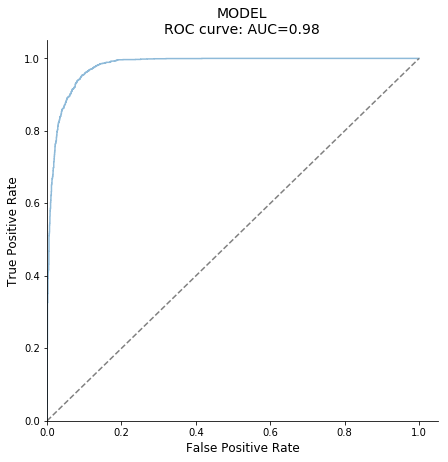

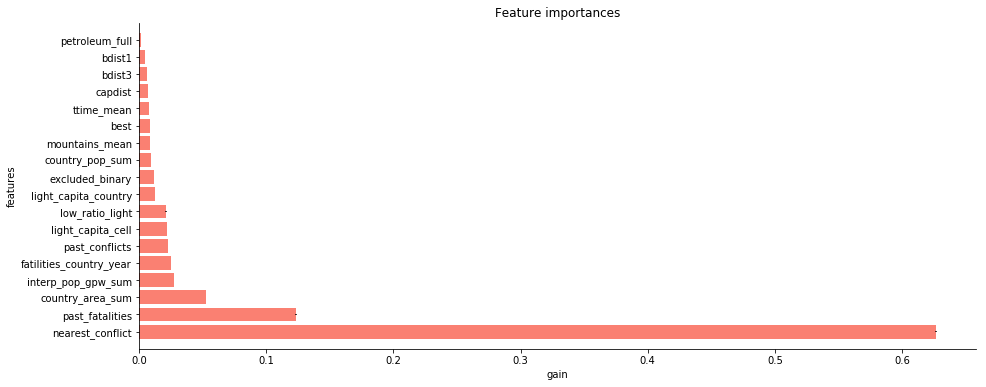

In [288]:
auc_plot(dict_of_metrics_in_years)
ap_plot(dict_of_metrics_in_years)
recall_precision_plot(dict_of_metrics_in_years)

prc_plot(dict_of_metrics_in_years)
roc_plot(dict_of_metrics_in_years)
feature_imp_plot(dict_of_metrics_in_years)

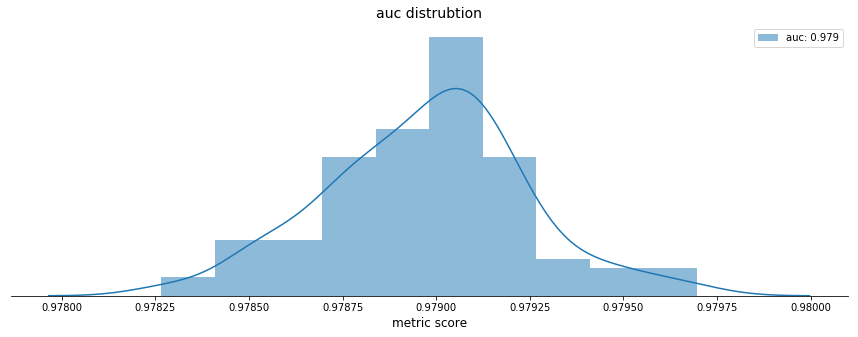

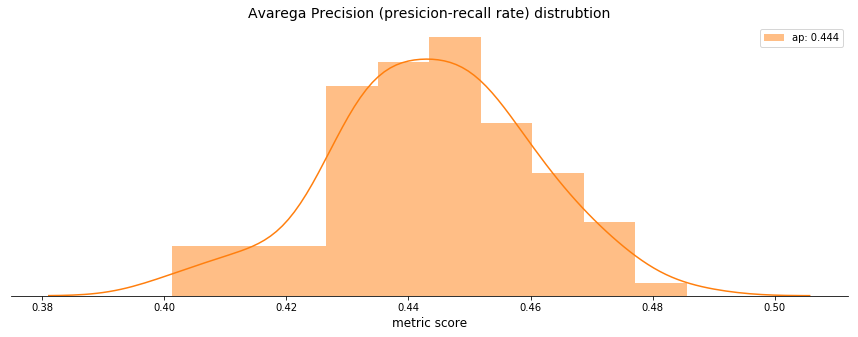

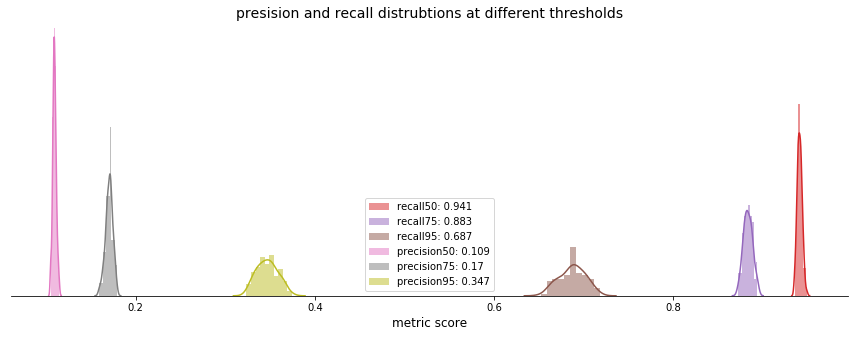

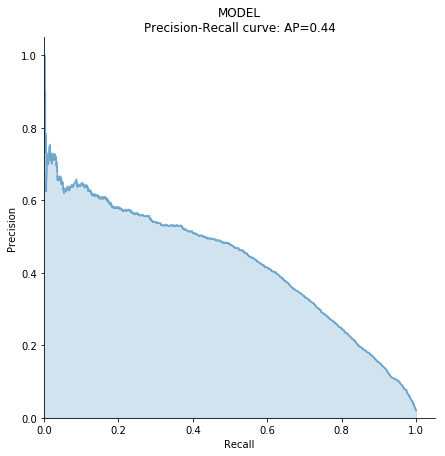

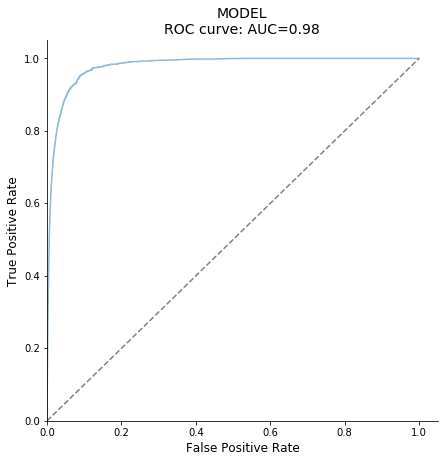

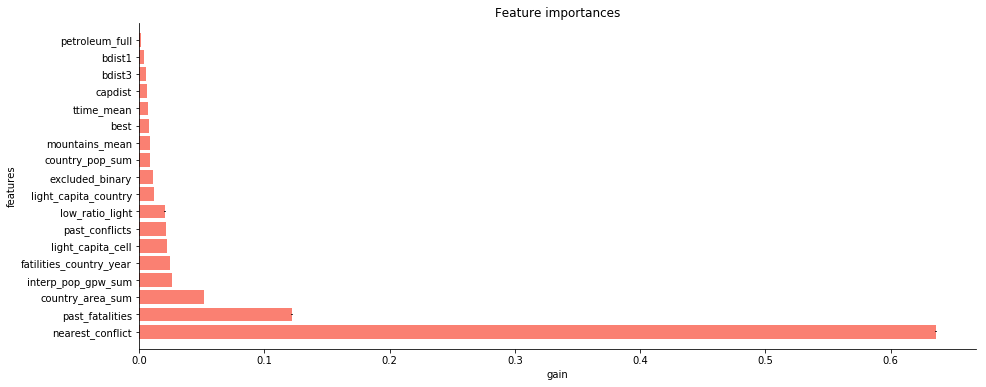

In [289]:
auc_plot(dict_of_metrics_out_years)
ap_plot(dict_of_metrics_out_years)
recall_precision_plot(dict_of_metrics_out_years)

prc_plot(dict_of_metrics_out_years)
roc_plot(dict_of_metrics_out_years)
feature_imp_plot(dict_of_metrics_out_years)

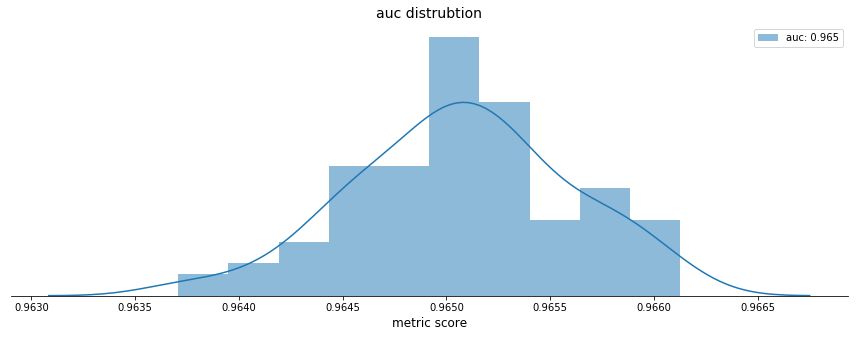

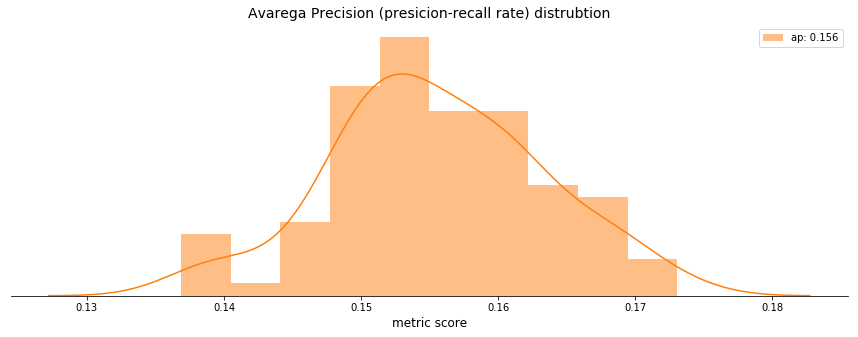

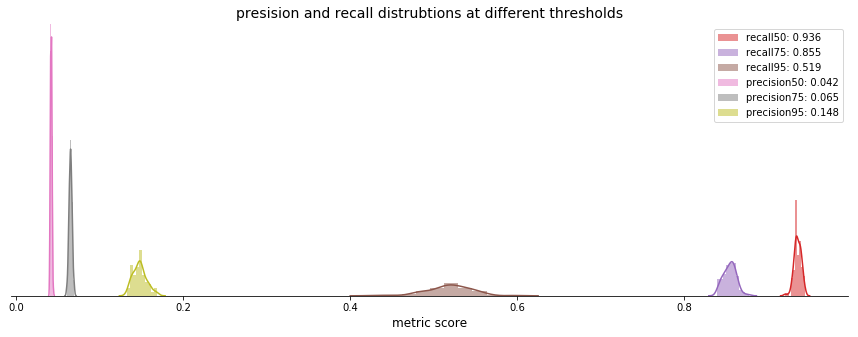

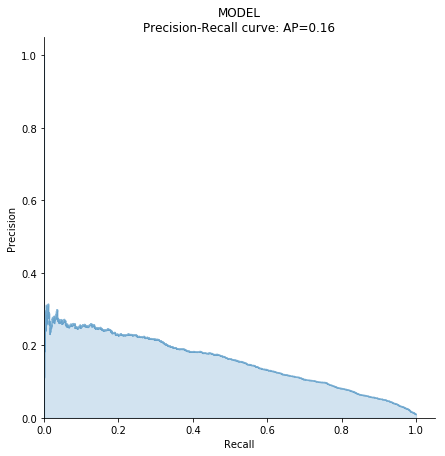

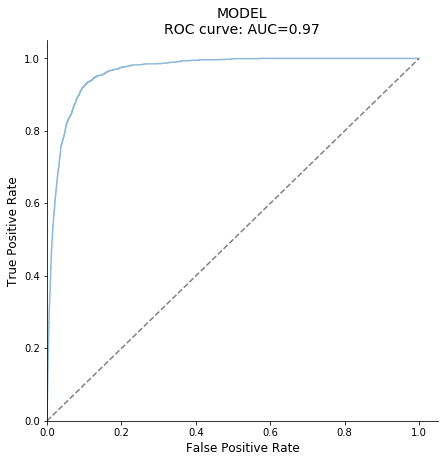

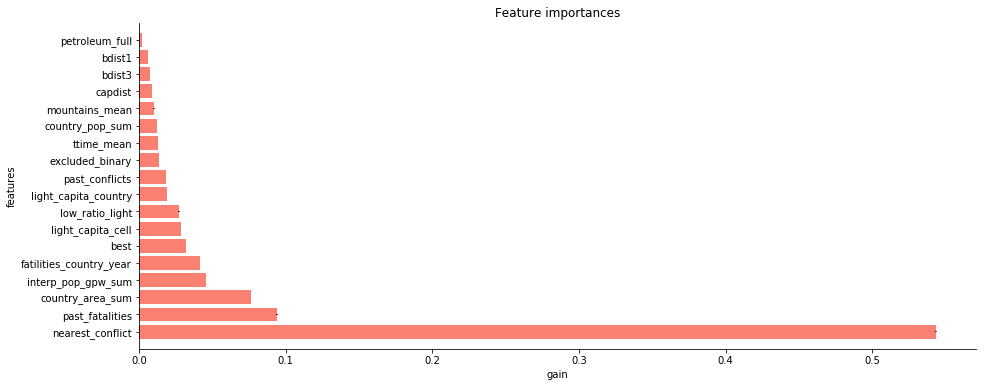

In [290]:
auc_plot(dict_of_metrics_out_years_onsets)
ap_plot(dict_of_metrics_out_years_onsets)
recall_precision_plot(dict_of_metrics_out_years_onsets)

prc_plot(dict_of_metrics_out_years_onsets)
roc_plot(dict_of_metrics_out_years_onsets)
feature_imp_plot(dict_of_metrics_out_years_onsets)

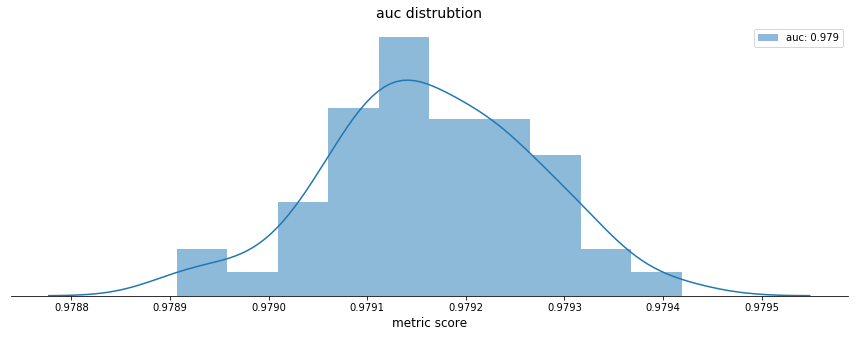

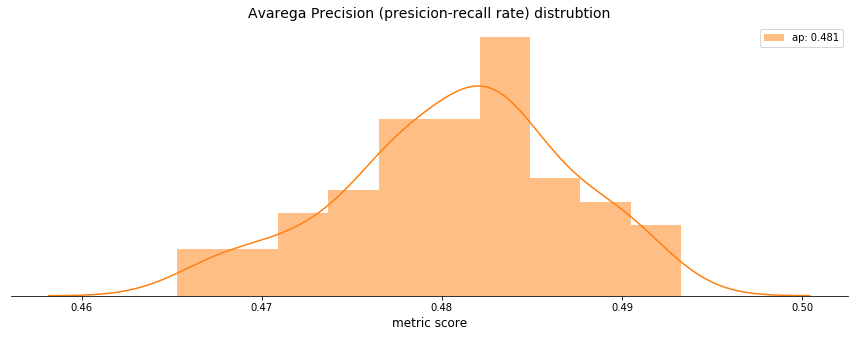

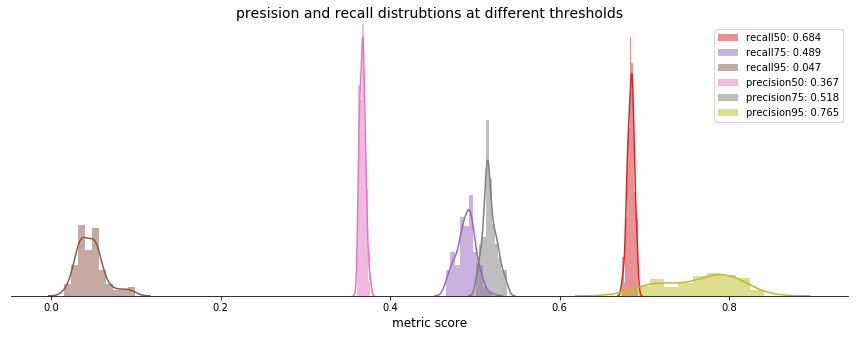

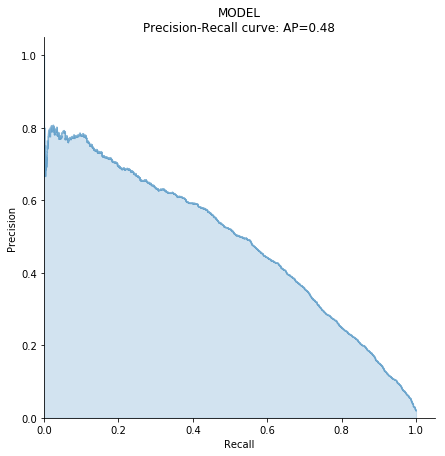

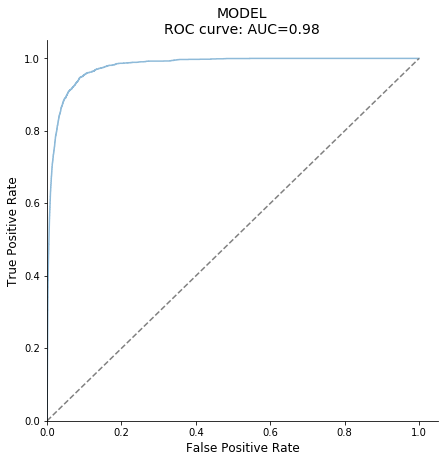

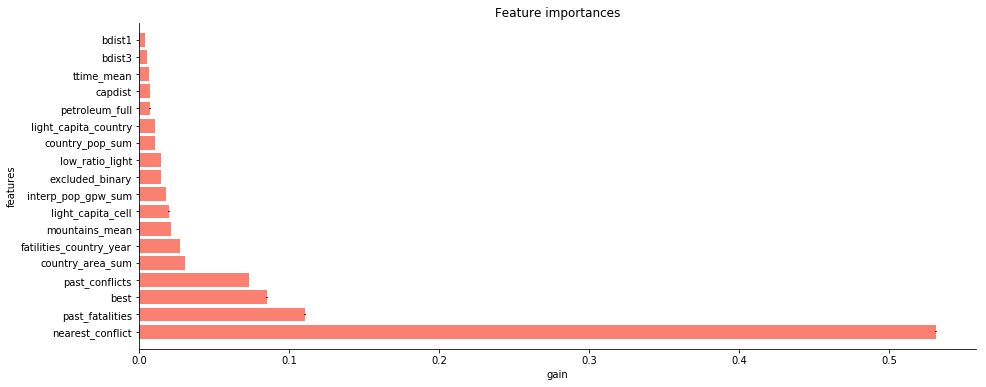

In [291]:
auc_plot(dict_of_metrics_out_years20)
ap_plot(dict_of_metrics_out_years20)
recall_precision_plot(dict_of_metrics_out_years20)

prc_plot(dict_of_metrics_out_years20)
roc_plot(dict_of_metrics_out_years20)
feature_imp_plot(dict_of_metrics_out_years20)

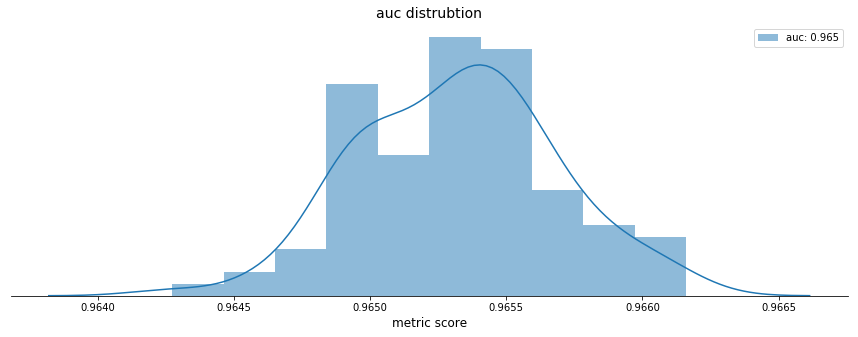

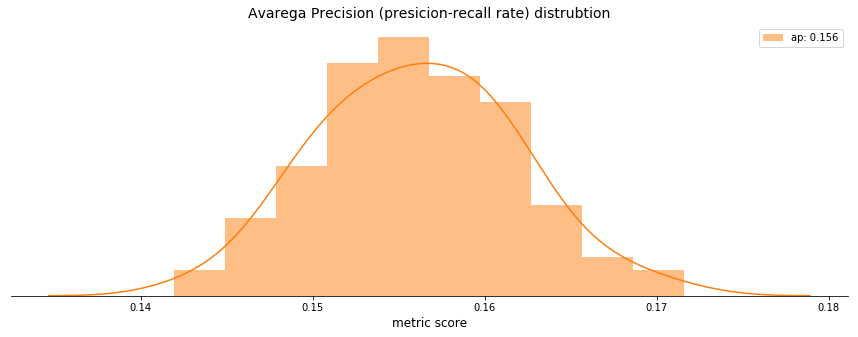

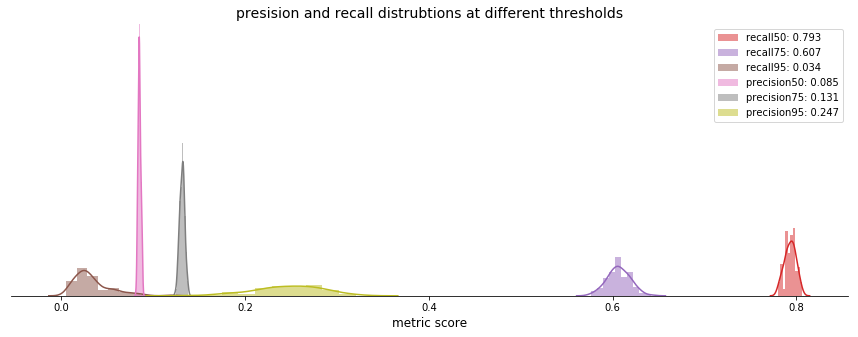

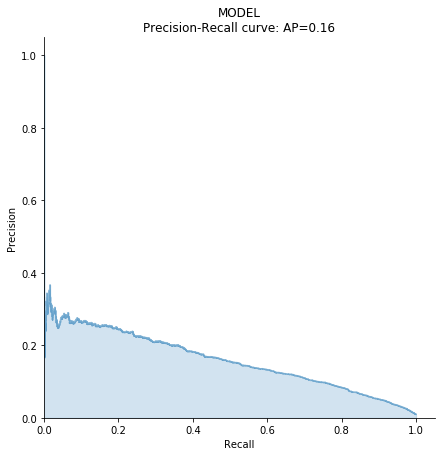

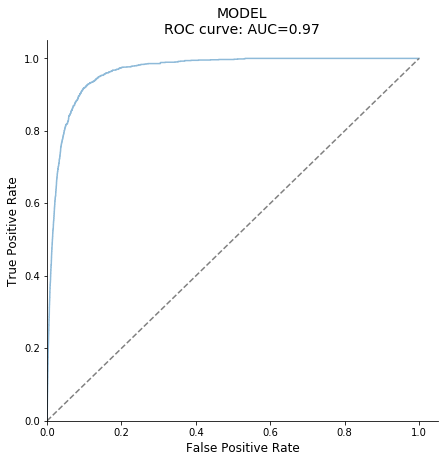

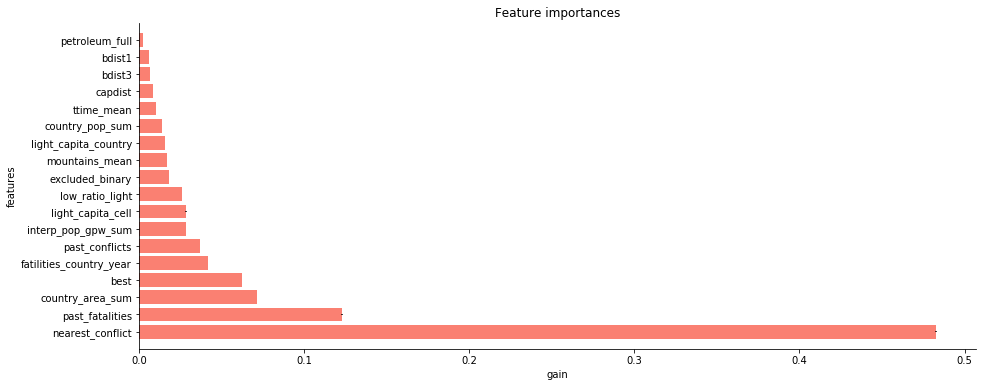

In [292]:
auc_plot(dict_of_metrics_out_years_onsets5)
ap_plot(dict_of_metrics_out_years_onsets5)
recall_precision_plot(dict_of_metrics_out_years_onsets5)

prc_plot(dict_of_metrics_out_years_onsets5)
roc_plot(dict_of_metrics_out_years_onsets5)
feature_imp_plot(dict_of_metrics_out_years_onsets5)


Now plot a map of true and predicted conflicts in 2006

In [28]:
df_test_years = df[df['year']>2005].copy()


In [29]:
np.array(dict_of_metrics_out_years['preds'])[0,:][:,1].shape # right not just one of the estimates and not the 'posterior' mean


(253548,)

In [30]:
df_test_years['pred_lead_prob_best'] = np.array(dict_of_metrics_out_years['preds'])[0,:][:,1]
df_test_years['pred_lead_prob_best20'] = np.array(dict_of_metrics_out_years20['preds'])[0,:][:,1]

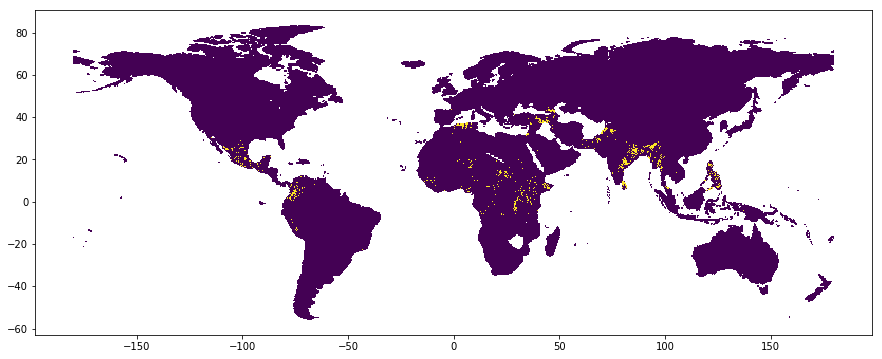

In [31]:
df_test_years[df_test_years['year']==2006].plot(column = 'lead_binary_best', figsize=(15, 15))
plt.show()

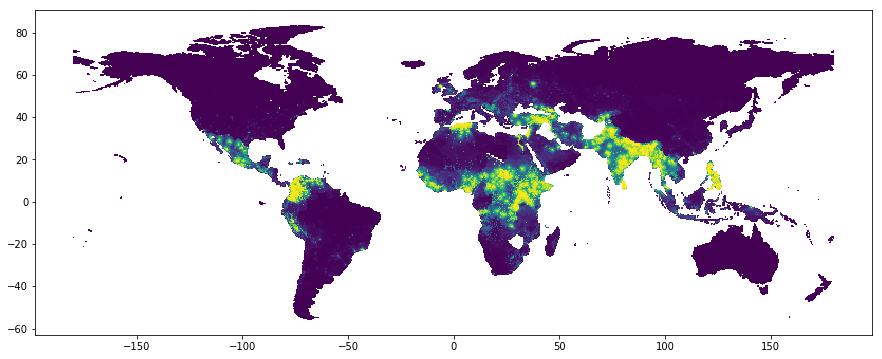

In [32]:
df_test_years[df_test_years['year']==2006].plot(column = 'pred_lead_prob_best', figsize=(15, 15))
plt.show()


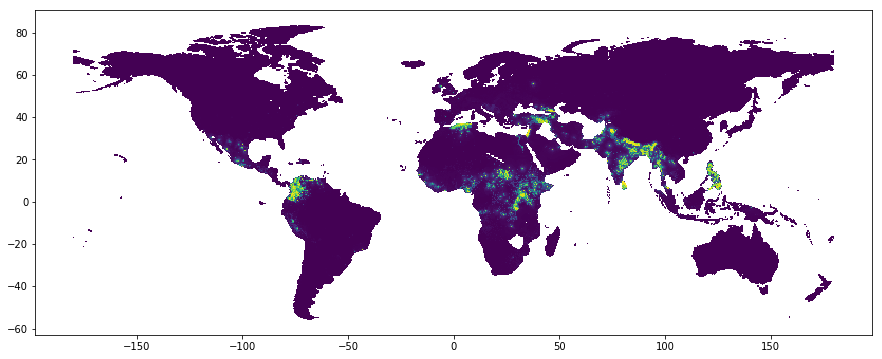

In [33]:
df_test_years[df_test_years['year']==2006].plot(column = 'pred_lead_prob_best20', figsize=(15, 15))
plt.show()

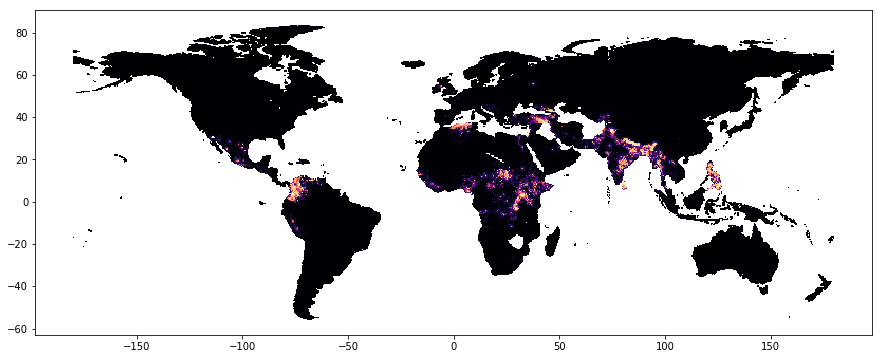

In [34]:
df_test_years[df_test_years['year']==2006].plot(column = 'pred_lead_prob_best20', figsize=(15, 15), cmap='magma')
plt.show()


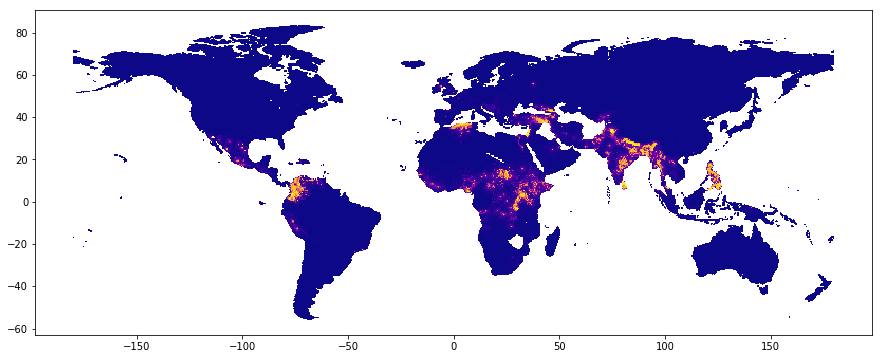

In [35]:
df_test_years[df_test_years['year']==2006].plot(column = 'pred_lead_prob_best20', figsize=(15, 15), cmap='plasma')
plt.show()


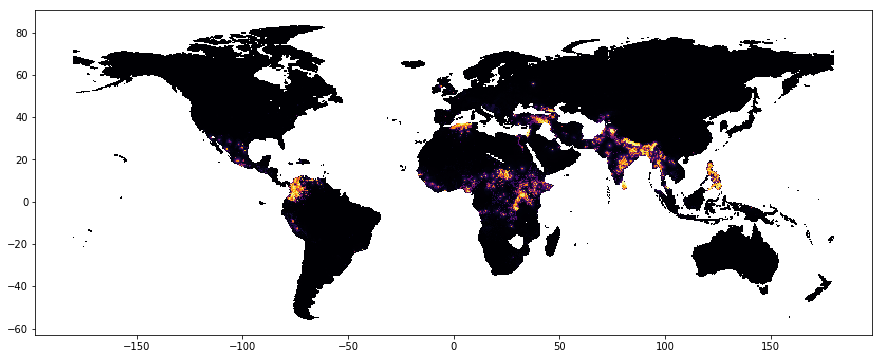

In [36]:
df_test_years[df_test_years['year']==2006].plot(column = 'pred_lead_prob_best20', figsize=(15, 15), cmap='inferno')
plt.show()


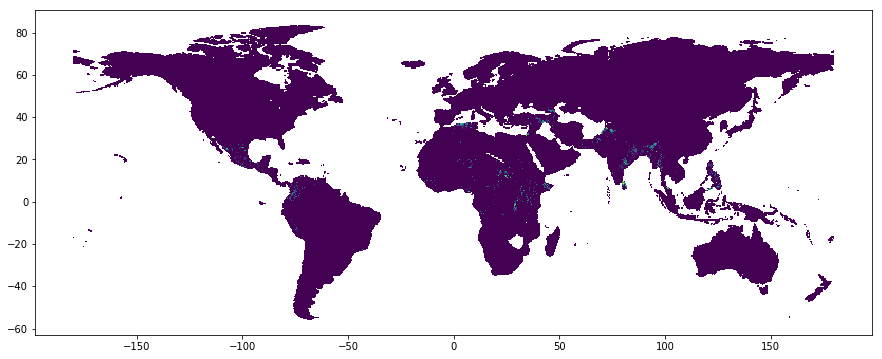

In [37]:
df_test_years[df_test_years['year']==2007].plot(column = 'log_best', figsize=(15, 15))
plt.show()

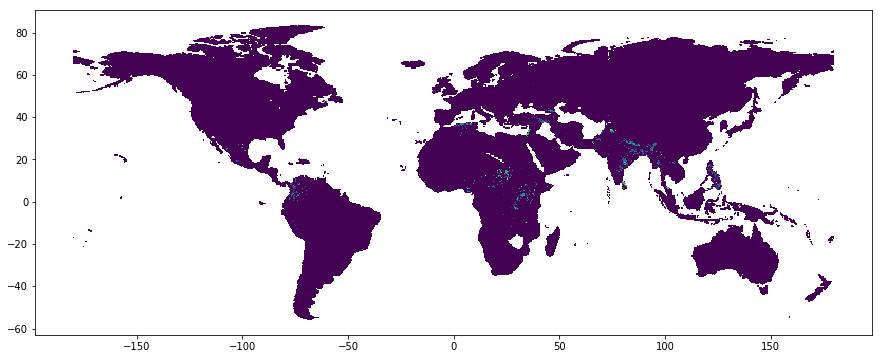

In [38]:
df_test_years[df_test_years['year']==2006].plot(column = 'log_best', figsize=(15, 15))
plt.show()

# Some tests

In [39]:
np.array(dict_of_metrics_out_years20['preds'])[0]

array([[9.9992424e-01, 7.5769742e-05],
       [9.9992424e-01, 7.5769742e-05],
       [9.9992424e-01, 7.5769742e-05],
       ...,
       [9.9971467e-01, 2.8529888e-04],
       [9.9971467e-01, 2.8529888e-04],
       [9.9971467e-01, 2.8529888e-04]], dtype=float32)